 FEATURE ENGINEERING :
 Dealing With Outliers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [6]:
def load():
    data = pd.read_csv("titanic.csv")
    return data


df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


1. Outliers

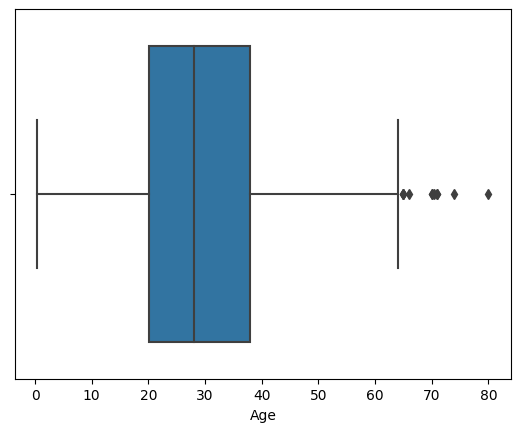

In [7]:
sns.boxplot(x=df["Age"])
plt.show()

In [8]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)

iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

df[(df["Age"] < low) | (df["Age"] > up)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [9]:
df[(df["Age"] < low) | (df["Age"] > up)]["Age"]

33    66.000
54    65.000
96    71.000
116   70.500
280   65.000
456   65.000
493   71.000
630   80.000
672   70.000
745   70.000
851   74.000
Name: Age, dtype: float64

In [10]:
df[(df["Age"] < low) | (df["Age"] > up)].index

Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

Is there an outlier?

In [11]:
df[(df["Age"] > up) | (df["Age"] < low)].any(axis=None)

True

In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [13]:
outlier_thresholds(df, "Age")

(-74.0, 134.0)

In [14]:
outlier_thresholds(df, "Fare")

(-150.056225, 269.360375)

In [18]:
low, up = outlier_thresholds(df, "Age")

In [19]:
df[(df["Age"] < low) | (df["Age"] > up)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [20]:
df[(df["Age"] < low) | (df["Age"] > up)]["Age"]

Series([], Name: Age, dtype: float64)

In [21]:
df[(df["Age"] < low) | (df["Age"] > up)].index

Int64Index([], dtype='int64')

In [22]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [23]:
check_outlier(df, "Age")

False

In [24]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [26]:
for col in num_cols:
    print(col, check_outlier(df, col))

PassengerId False
Age False
Fare True


In [27]:
dff = load_application_train()

In [28]:
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 242712
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


In [29]:
for col in num_cols:
    print(col, check_outlier(dff, col))

SK_ID_CURR False
CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE False
DAYS_BIRTH False
DAYS_EMPLOYED False
DAYS_REGISTRATION False
DAYS_ID_PUBLISH False
OWN_CAR_AGE False
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START False
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG False
FLOORSMIN_AVG False
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE False
FLOORSMIN_MODE False
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_ME

In [30]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [31]:
grab_outliers(df, "Fare")

     PassengerId  Survived  Pclass                                Name     Sex    Age  SibSp  Parch    Ticket    Fare        Cabin Embarked
258          259         1       1                    Ward, Miss. Anna  female 35.000      0      0  PC 17755 512.329          NaN        C
679          680         1       1  Cardeza, Mr. Thomas Drake Martinez    male 36.000      0      1  PC 17755 512.329  B51 B53 B55        C
737          738         1       1              Lesurer, Mr. Gustave J    male 35.000      0      0  PC 17755 512.329         B101        C


In [32]:
grab_outliers(df, "Age", True)

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


Int64Index([], dtype='int64')

In [33]:
check_outlier(df, "Age")

False

In [34]:
grab_outliers(df, "Age")

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


Remove Outlier

In [36]:
low, up = outlier_thresholds(df, "Fare")
df.shape

(891, 12)

In [37]:
df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

(888, 12)

In [38]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [39]:
df.shape

remove_outlier(df, "Fare").shape

(888, 12)